In [1]:

import json 
import os
import re

import requests



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split



import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.datasets import text_classification

from torchtext.data import Field, Example, TabularDataset
from torchtext.data import BucketIterator
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
from gensim.utils import simple_preprocess

# NLTK
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud


import warnings 




Extract data from json files

In [2]:
def extract_json_object(filename):
    with open(file, "r", encoding='utf-8') as read_file:
        json_array = json.load(read_file)
    json_data = []    
    #parse the data
    for item in json_array:
        details = {"id":None, "labels":None, "text":None}
        details['id'] = item['id']
        try: 
            details['labels'] = item['labels']
        except KeyError: 
            details['labels'] = []         
        details['text'] = item['text']
        json_data.append(details)

    
    return json_data


Setup for extracting from data files

In [3]:
# file paths
lst_file_path=[]

lst_file_path.append("data/dev_set_task1.txt")
lst_file_path.append("data/test_set_task1.txt")
lst_file_path.append("data/training_set_task1.txt")


# List of keys 
dataset = ["dev", "test", "training"] 
# empty dictionary
dic_datasets =  dict.fromkeys(dataset, pd.DataFrame()) 

  



Load data files into a dictionary of datasets

In [4]:

for i, file in enumerate(lst_file_path):
    print('loading'+ file)
    dic_datasets[dataset[i]] = pd.DataFrame(extract_json_object(extract_json_object))
    

loadingdata/dev_set_task1.txt
loadingdata/test_set_task1.txt
loadingdata/training_set_task1.txt


Peak at dictioanry

In [5]:
print(type(dic_datasets))
print(dic_datasets['training'].keys())
print(dic_datasets['training']['text'].head())



<class 'dict'>
Index(['id', 'labels', 'text'], dtype='object')
0      THERE ARE ONLY TWO GENDERS\n\nFEMALE \n\nMALE\n
1                             This is not an accident!
2    SO BERNIE BROS HAVEN'T COMMITTED VIOLENCE EH?\...
3    PATHETIC\n\nThe Cowardly Asshole\nWeak Failure...
4    WHO TRUMP REPRESENTS\n\nWHO DEMOCRATS REPRESENT\n
Name: text, dtype: object


begin descriptive analysis for training set, text

source : https://github.com/HurmetNoka/religion_on_twitter



Get a count of words in the training dataset text object 

In [8]:
count = dic_datasets['training']['text'].str.split().str.len()
count.index = count.index.astype(str) + ' words:'
count.sort_index(inplace=True)

In [9]:
print("Total number of words:", count.sum(), "words")

Total number of words: 12358 words


Number of words per text row

In [10]:
print("Mean number of words per Text:", round(count.mean(),2), "words")

Mean number of words per Text: 17.96 words


Get text length

dic_datasets['training']["Text_length"] = dic_datasets['training']['text'].str.len()
print("Total length of the dataset is:", dic_datasets['training'].Text_length.sum(), "characters")

In [12]:
print("Mean Length of a Text is:", round(dic_datasets['training'].Text_length.mean(),0), "characters")
dic_datasets['training'] = dic_datasets['training'].drop(['Text_length'], axis=1)

Mean Length of a Text is: 104.0 characters


Clean up dataset by removing user names (if they exist)

In [13]:
def remove_users(Text, pattern1, pattern2):
    r = re.findall(pattern1, Text)
    for i in r:
        Text = re.sub(i, '', Text)
    
    r = re.findall(pattern2, Text)
    for i in r:
        Text = re.sub(i, '', Text)
    return Text

In [14]:
dic_datasets['training']['tidy_Text'] = np.vectorize(remove_users)(dic_datasets['training']['text'], "@ [\w]*", "@[\w]*")

lower case all values

In [15]:
dic_datasets['training']['tidy_Text']  = dic_datasets['training']['tidy_Text'] .str.lower()

remove hash tags

In [16]:
dic_datasets['training']['hashtags'] = dic_datasets['training']['tidy_Text']  .apply(lambda twt : re.findall(r"# (\w+)", twt))

 count number of hash tags

In [17]:
d = Counter(dic_datasets['training'].hashtags.sum())
df_hashtags = pd.DataFrame([d]).T

In [18]:
Counter(dic_datasets['training'].hashtags.sum())

Counter({'45': 1})

In [19]:
df_hashtags.columns = ['freq']
df_hashtags.freq.sum()

1

In [20]:
df_hashtags.sort_values(by=['freq'], ascending=False, inplace=True)

frequency table of hashtags by hash tag

In [21]:
df_hashtags.head(20)

,freq
45,1


In [22]:
dic_datasets['training'] = dic_datasets['training'].drop(['hashtags'], axis=1)

remove hashtags

In [23]:
def remove_hashtags(Text, pattern1, pattern2):
    r = re.findall(pattern1, Text)
    for i in r:
        Text = re.sub(i, '', Text)
    
    r = re.findall(pattern2, Text)
    for i in r:
        Text = re.sub(i, '', Text)
    return Text

In [24]:
dic_datasets['training']['tidy_Text'] = np.vectorize(remove_hashtags)(dic_datasets['training']['tidy_Text'], "# [\w]*", "#[\w]*")

remove links

In [25]:
def remove_links(Text):
    Text_no_link = re.sub(r"http\S+", "", Text)
    return Text_no_link

In [26]:
dic_datasets['training']['tidy_Text'] = np.vectorize(remove_links)(dic_datasets['training']['tidy_Text'])

 Removing Punctuations, Numbers, and Special Characters 

In [27]:
dic_datasets['training']['tidy_Text'] = dic_datasets['training']['tidy_Text'].str.replace("[^a-zA-Z#]", " ")

remove short words

In [28]:
dic_datasets['training']['tidy_Text'] = dic_datasets['training']['tidy_Text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

tokenize

In [29]:
def tokenize(Text):
    for word in Text:
        yield(gensim.utils.simple_preprocess(str(word), deacc=True))  # deacc=True Removes punctuations

In [30]:
dic_datasets['training']['tidy_Text_tokens'] = list(tokenize(dic_datasets['training']['tidy_Text']))

prepare stop words

In [31]:
# Prepare Stop Words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'https', 'twitter', 'pic','twitt',])

remove stop words

In [32]:
def remove_stopwords(Texts):
    return [[word for word in simple_preprocess(str(Text)) if word not in stop_words] for Text in Texts]

In [33]:
dic_datasets['training']['tokens_no_stop'] = remove_stopwords(dic_datasets['training']['tidy_Text_tokens'])

Drop rows having less than three tokens

In [34]:
dic_datasets['training']['length'] = dic_datasets['training']['tokens_no_stop'].apply(len)
df = dic_datasets['training'].drop(dic_datasets['training'][dic_datasets['training']['length']<3].index)

In [35]:
dic_datasets['training'] = dic_datasets['training'].drop(['length'], axis=1)
df.shape

(643, 7)

In [36]:
dic_datasets['training'].reset_index(drop=True, inplace=True)

Word cloud

In [37]:
# Join the Text back together
def rejoin_words(row):
    words = row['tokens_no_stop']
    joined_words = (" ".join(words))
    return joined_words

In [38]:
dic_datasets['training']['no_stop_joined'] = dic_datasets['training'].apply(rejoin_words, axis=1)

In [39]:
all_words = ' '.join([text for text in dic_datasets['training']['no_stop_joined']])

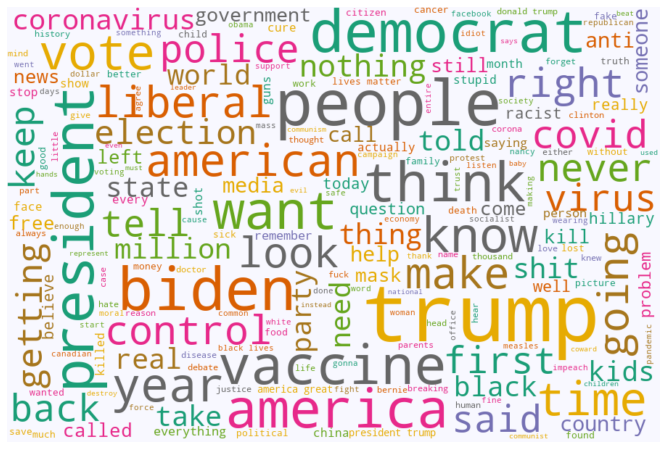

In [40]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='Dark2').generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Cleaning Effects  Length of Text

In [41]:
dic_datasets['training']["Text_length"] = dic_datasets['training']["text"].str.len()
dic_datasets['training']["cleaned_Text_length"] = dic_datasets['training']["no_stop_joined"].str.len()
df_lengths = dic_datasets['training'][['Text_length', 'cleaned_Text_length']]

D:\Users\sync\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Users\sync\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


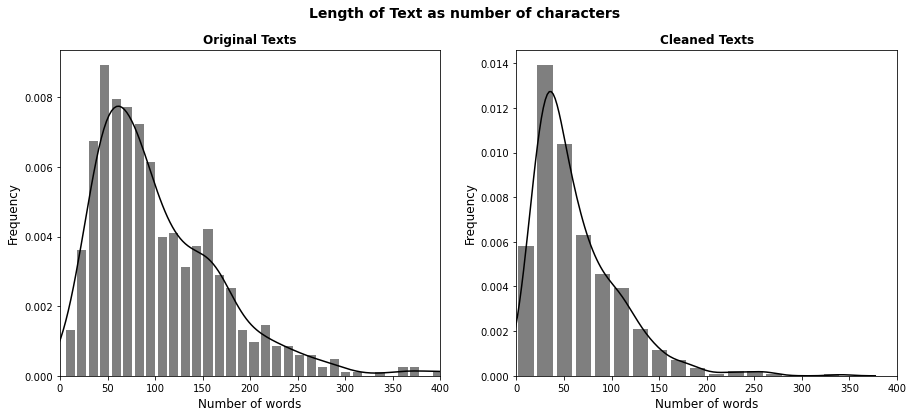

In [42]:
x1 = df_lengths.Text_length
x2 = df_lengths.cleaned_Text_length
plt.figure(figsize=(15,6))
plt.suptitle('Length of Text as number of characters', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x1, color="black", label="No. Words", bins=35, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Texts",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="black", label="No. Words", bins=17, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Texts",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,400])

plt.show()

Cleaning Effects Number of Words

In [43]:
dic_datasets['training']["Text_words"] = dic_datasets['training']['text'].str.split().str.len()
dic_datasets['training']["cleaned_Text_words"] = dic_datasets['training']["no_stop_joined"].str.split().str.len()
df_lengths = dic_datasets['training'][['Text_words', 'cleaned_Text_words']]

D:\Users\sync\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Users\sync\anaconda3\envs\pytorch\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


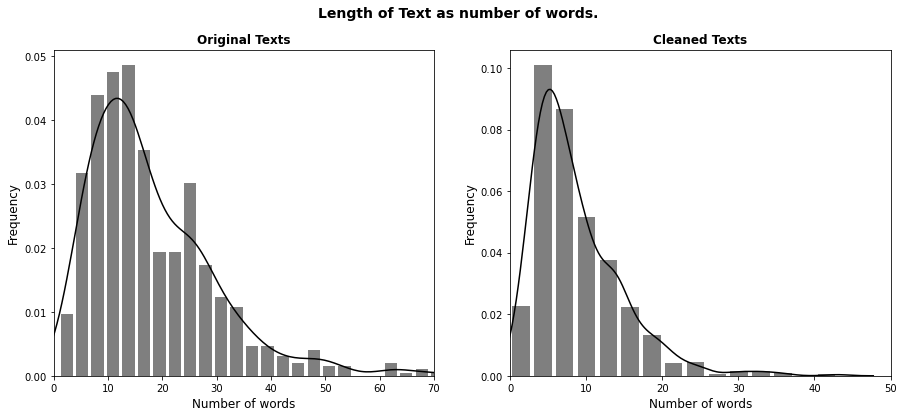

In [44]:
x_1 = df_lengths.Text_words
x_2 = df_lengths.cleaned_Text_words
plt.figure(figsize=(15,6))
plt.suptitle('Length of Text as number of words.', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)
sns.distplot(x_1, color="black", label="No. Words", bins=25, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title("Original Texts",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,70])



# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x_2, color="black", label="No. Words", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Cleaned Texts",fontsize=12, fontweight="bold")
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim([0,50])

plt.show()

Top 25 Most frequent Words¶

In [45]:
dic_datasets['training'] = dic_datasets['training'].drop(['Text_length', 'cleaned_Text_length', 'Text_words', 'cleaned_Text_words'], axis=1)

In [46]:
word_freq = pd.Series(np.concatenate([x.split() for x in dic_datasets['training'].no_stop_joined])).value_counts()

In [47]:
word_df = pd.Series.to_frame(word_freq)
word_df['word'] = list(word_df.index)
word_df.reset_index(drop=True, inplace=True)
word_df.columns = ['freq', 'word']

Unique words: 2707


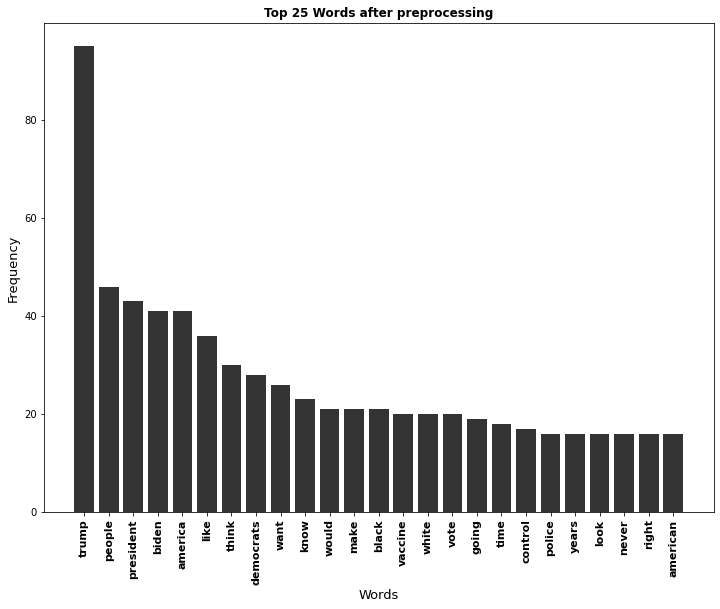

In [48]:
label = word_df['word'].head(25)
freq = word_df['freq'].head(25)
index = np.arange(len(freq))

print("Unique words:", len(word_df))
plt.figure(figsize=(12,9))
plt.bar(index, freq, alpha=0.8, color= 'black')
plt.xlabel('Words', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.xticks(index, label, fontsize=11, rotation=90, fontweight="bold") 
plt.title('Top 25 Words after preprocessing', fontsize=12, fontweight="bold")
plt.show()

In [53]:
dic_datasets['training'].to_pickle('training.pkl')
dic_datasets['dev'].to_pickle('dev.pkl')
dic_datasets['test'].to_pickle('test.pkl')